# Cutting-Edge project - Milliman


- Members: **Amal BACHA - Dalia BARBI - Khalil BATTIKH - Lucas RODRIGUEZ - Naïm SOUNI**
- Group 2
- Professional partner: **[Milliman](https://www.milliman.com/en/)**

*January 2023 - Present*

---

## Preliminaries

To execute this Jupyter Notebook on a local environment or on a Google Colab/Binder online system, please make sure you have all the prerequisites installed.

- If you are using **`pip`** for packaging management, please run:

In [1]:
#!pip install -r requirements.txt

- If you are using **`pip3`** for packaging management, please run:

In [2]:
!pip3 install -r requirements.txt


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


- If you are using **`conda`** (Anaconda) for packaging management, please run:

In [1]:
!conda install --yes --file requirements.txt

zsh:1: command not found: conda


---

The next cell imports all the required Python modules.

In [1]:
from src.Constants import *
from src.Utils import *
from src.EquityModel import *
from src.RatesModel import *
from src.Vasicek import *
from src.CIR import *
from src.HullWhite import *
from src.BlackScholes import *

## Interest rates modelling

### Vasicek

In [2]:
# Default Vasicek model
model = Vasicek(0.01875, 0.20, 0.01, 0.012) # r0, kappa, theta, sigma

In [3]:
# Displaying information on Vasicek model
model

Vasicek model (r0 = 0.01875, kappa = 0.2, theta = 0.01, eta = 0.012))

In [4]:
# Casting the results into a pandas DataFrame
df = Utils.cast_df(model.simulate_euler(T=3, N = 1000))

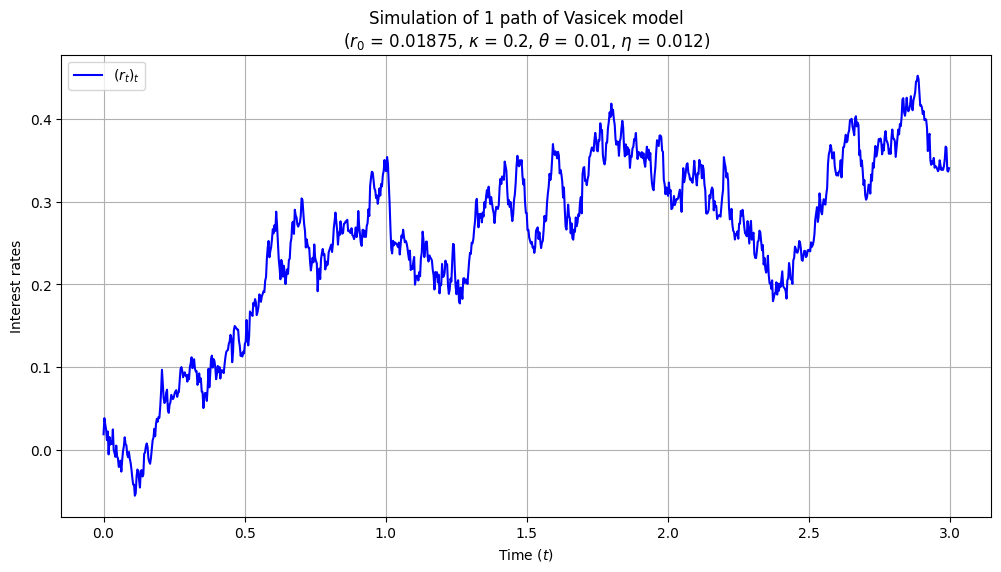

In [5]:
# Simulation of a trajectory
_ = df.plot(figsize=(12, 6), color="blue", x="t", y ="r", label="$(r_t)_t$")
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of 1 path of Vasicek model\n{model.get_parameter_string()}")
_ = plt.legend()

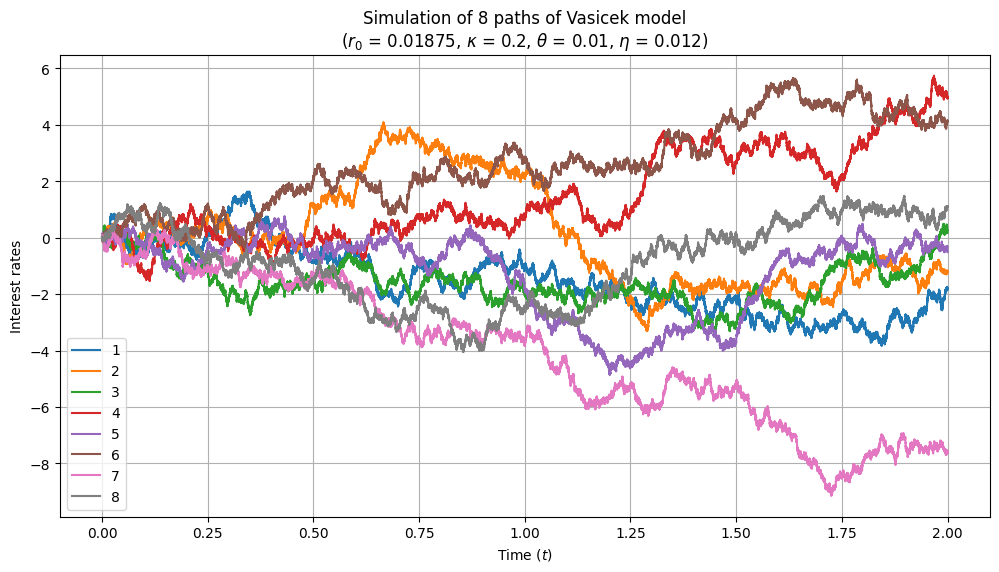

In [10]:
# Simulation of several trajectories
NB_TRAJECTORIES = 8
_ = Utils.cast_df(model.simulate_paths(NB_TRAJECTORIES, T = 2)).T.plot(x = 0, y = list(range(1, NB_TRAJECTORIES + 1)), figsize=(12, 6))
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of {NB_TRAJECTORIES} paths of Vasicek model\n{model.get_parameter_string()}")
_ = plt.legend()

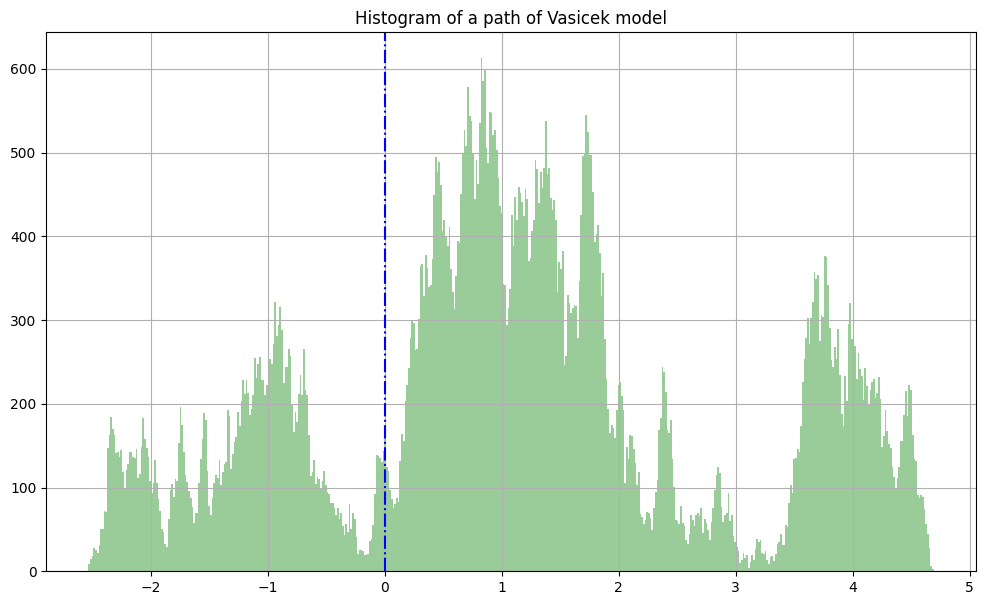

In [11]:
# Histogram of a path
_ = df["r"].hist(bins=int(5e2), figsize=(12, 7), color="green", alpha=0.4)
_ = plt.title("Histogram of a path of Vasicek model")
_ = plt.axvline(x = 0, ls = "-.", color="blue")

In [8]:
# Normality test (Shapiro-Wilk + Jarque-Bera)
TEST_THRESHOLD_ALPHA = 5e-2 # Threshold for p-value

# Definition of normality tests (Shapiro-Wilf + Jarque-Bera)
normtest_shapiro = lambda x: scipy.stats.shapiro(x).pvalue > TEST_THRESHOLD_ALPHA 
normtest_jarquebera = lambda x:scipy.stats.jarque_bera(x).pvalue > TEST_THRESHOLD_ALPHA

### Cox-Ingersoll-Ross (CIR)

In [12]:
# Default CIR model
model = CIR(0.4, 0.20, 0.01, 0.12)

In [13]:
# Displaying information on Vasicek model
model

CIR model (r0 = 0.4, kappa = 0.2, theta = 0.01, sigma = 0.12))

In [18]:
# Casting the results into a pandas DataFrame
df = Utils.cast_df(model.simulate_euler(T=3))

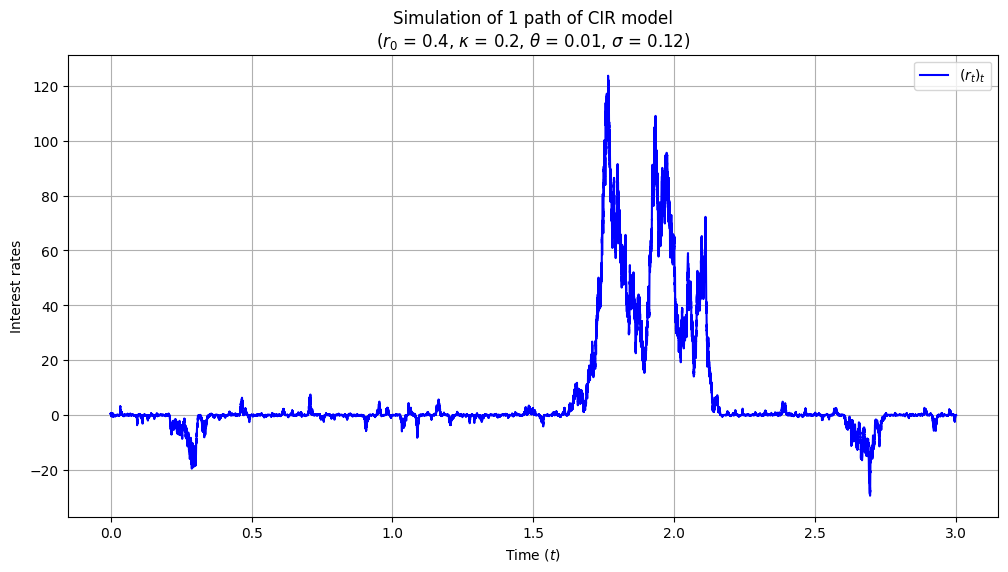

In [19]:
# Simulation of a trajectory
_ = df.plot(figsize=(12, 6), color="blue", x="t", y ="r", label="$(r_t)_t$")
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of 1 path of CIR model\n{model.get_parameter_string()}")
model.plot_feller_line()

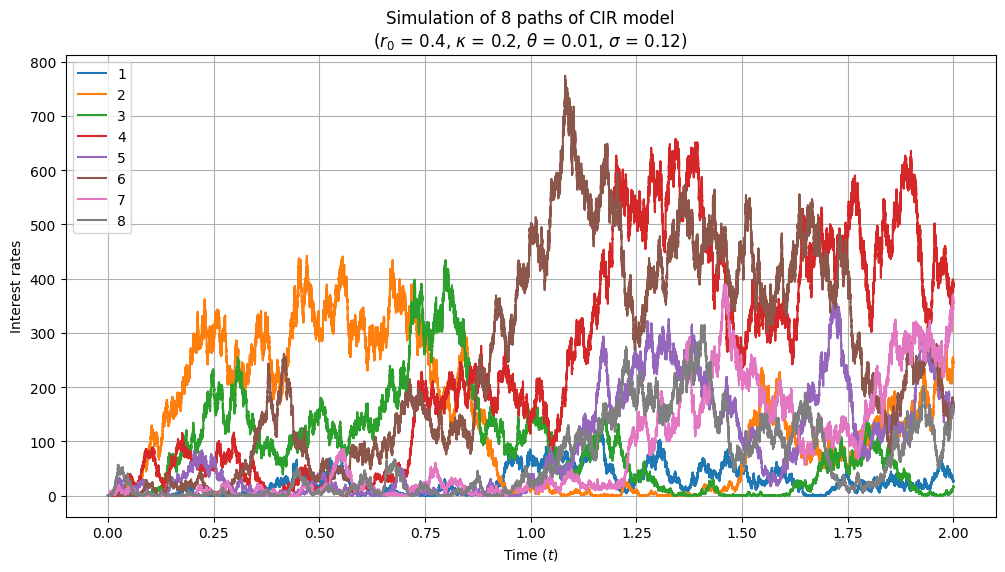

In [16]:
# Simulation of several trajectories
NB_TRAJECTORIES = 8
_ = Utils.cast_df(model.simulate_paths(NB_TRAJECTORIES, scheme=Constants.Scheme.MILSTEIN, T=2)).T.plot(x = 0, y = list(range(1, NB_TRAJECTORIES + 1)), figsize=(12, 6))
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of {NB_TRAJECTORIES} paths of CIR model\n{model.get_parameter_string()}")
_ = plt.legend()

**Remark**: Strange behavior of the simulated curves because of the $\sqrt{\bullet}$ with negative rates when Feller condition is not satisfied.
- To be studied (one alternative is to add $\sqrt{|\bullet|}$ to handle negative rates (created by floating point operations)

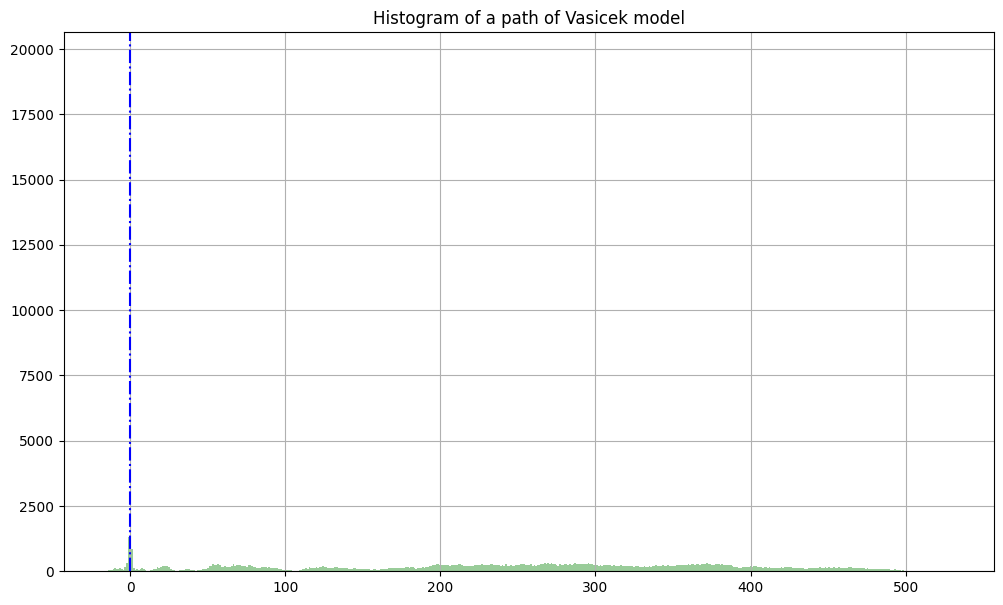

In [17]:
# Histogram of a path
_ = df["r"].hist(bins=int(5e2), figsize=(12, 7), color="green", alpha=0.4)
_ = plt.title("Histogram of a path of Vasicek model")
_ = plt.axvline(x = 0, ls = "-.", color="blue")

### Hull & White (HW) $\diamond$ Extended Vasicek

**Protocol**: Gathering the input term structure of interest rates in order to construct the $\theta : \left[0, T\right] \longrightarrow \mathbb{R}$ deterministic functional.

In [19]:
# Setting up a random evaluation Date
today_date = ql.Date(31,1,2013)
ql.Settings.instance().setEvaluationDate(today_date)

# Setting up the yield termstructure
forward_rate = 0.04875825 #5e-3
rate = ql.SimpleQuote(forward_rate)
rate_handle = ql.QuoteHandle(rate)

# Setting up the day count convention to Actual/365
day_count = ql.Actual365Fixed() 
# day_count = ql.Thirty360(ql.Thirty360.BondBasis)

# Creating the discount curve with its own handler
discount_curve = ql.FlatForward(today_date, rate_handle, day_count)
discount_curve.enableExtrapolation()

# Creating the handler
handler_YTS = ql.YieldTermStructureHandle(discount_curve)

The `yieldTermStructure` object provides an method which gives us the discount factor for a particular date (`QuantLib.Date` object) or time in years (with 0 = `evaluationDate`). This method is called `discount()`.  

We are using the **numpy** method `vectorize` to apply this function on arrays or list of times and then generate a plot of the discount curve.

**Reference**: 
1. https://ipythonquant.wordpress.com/2015/04/04/a-brief-introduction-to-the-quantlib-in-python/

In [20]:
discount = np.vectorize(handler_YTS.discount)
time_horizon = np.arange(0, 10, 1/12)

In [21]:
d = discount(time_horizon)
d

array([1.        , 0.99594506, 0.99190655, 0.98788443, 0.98387861,
       0.97988904, 0.97591565, 0.97195836, 0.96801713, 0.96409187,
       0.96018253, 0.95628905, 0.95241135, 0.94854937, 0.94470306,
       0.94087234, 0.93705716, 0.93325744, 0.92947313, 0.92570417,
       0.92195049, 0.91821204, 0.91448874, 0.91078054, 0.90708737,
       0.90340919, 0.89974591, 0.89609749, 0.89246387, 0.88884498,
       0.88524076, 0.88165116, 0.87807611, 0.87451556, 0.87096945,
       0.86743772, 0.86392031, 0.86041716, 0.85692822, 0.85345342,
       0.84999272, 0.84654604, 0.84311335, 0.83969457, 0.83628965,
       0.83289855, 0.82952119, 0.82615753, 0.8228075 , 0.81947107,
       0.81614816, 0.81283872, 0.80954271, 0.80626006, 0.80299072,
       0.79973464, 0.79649176, 0.79326203, 0.79004539, 0.7868418 ,
       0.7836512 , 0.78047354, 0.77730877, 0.77415682, 0.77101766,
       0.76789123, 0.76477747, 0.76167634, 0.75858779, 0.75551176,
       0.7524482 , 0.74939706, 0.7463583 , 0.74333186, 0.74031

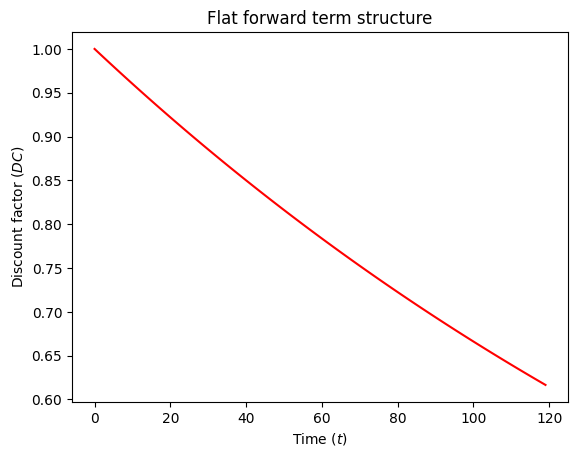

In [22]:
_ = pd.Series(d).plot(color="red")
_ = plt.title("Flat forward term structure")
_, _ = plt.xlabel("Time ($t$)"), plt.ylabel("Discount factor ($DC$)")

### Black–Karasinski

In [23]:
# TODO

### Ho-Lee

In [24]:
# TODO

## Equity modelling

### Generation of 2 $\rho$-correlated Brownian motions

<span style="color:black"><b>Remark</b>: We have to take into account the parameter $\rho \in \left[-1, 1\right]$ as the correlation between the two Brownian motions.</span>

-------------- Generation of Brownian Motions --------------
Simulated rho: 0.9960015444956383 	Given rho: 0.99
Absolute error: 0.006001544495638278


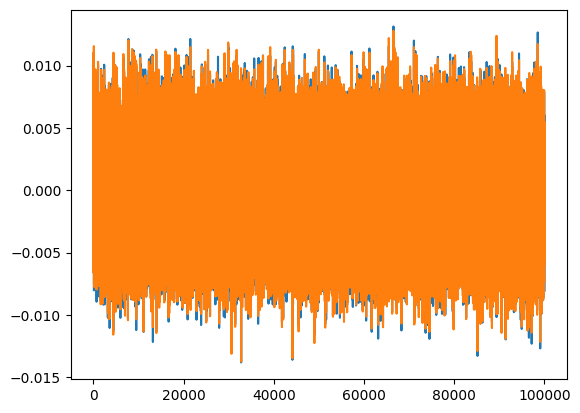

In [20]:
# Generation of Gaussian increments (Gaussian sequences)
for path in Utils.generate_correlated_gaussians(rho=0.99):
    plt.plot(path)

-------------- Generation of Brownian Motions --------------
Simulated rho: -0.5101060236435251 	Given rho: -0.9
Absolute error: 0.38989397635647494


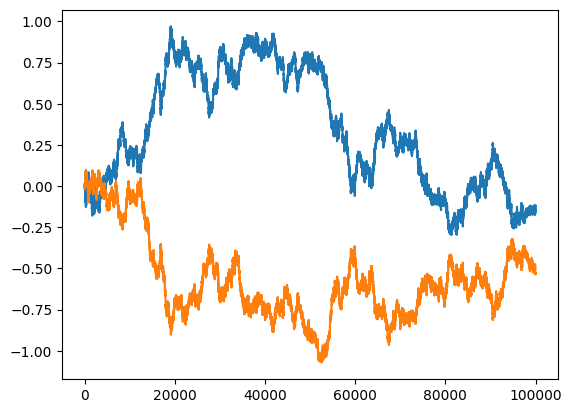

In [56]:
# Generation of Brownian motions (Cumulative sum of Gaussian increments)
for path in Utils.generate_correlated_brownians(rho=-0.9):
    plt.plot(path)

### Black-Scholes model $\diamond$ <span style="background:red; color:white; padding: 2px 6px">Constant drift/Constant volatility</span>

In [66]:
# TODO

### Black-Scholes model $\diamond$ <span style="background:red; color:white; padding: 2px 6px">Time-varying drift/Constant volatility</span>

In [2]:
S0 = 1
sigma = 0.7 # %
rho = 0.5
r = CIR(0.4, 0.20, 0.01, 0.12) # Vasicek(0.01875, 0.20, 0.01, 0.014)
model = BlackScholes(S0, r, sigma, rho)

In [3]:
d = model.simulate_euler(T=4.2, getRates=True)
df = pd.DataFrame(d)
df.head()

-------------- Generation of Brownian Motions --------------
Simulated rho: 0.8116932886651763 	Given rho: 0.5
Absolute error: 0.3116932886651763


,t,S,r
0,0.000000,1.000000,0.400000
1,0.000042,0.997497,0.400387
2,0.000084,0.997997,0.400236
3,0.000126,0.999694,0.400106
4,0.000168,0.999154,0.399845


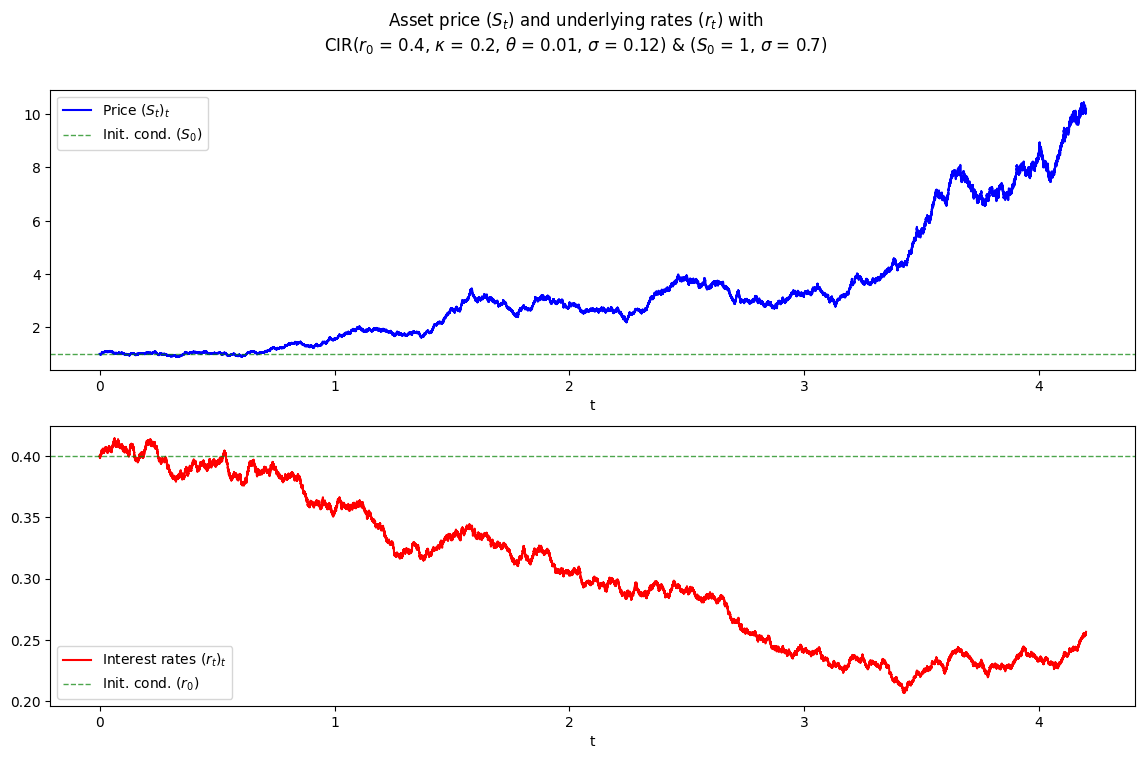

In [4]:
# Plotting the asset price and the interest rates evolution over time 
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
_ = df.plot(x = "t", y = "S", color="blue", label="Price $(S_t)_t$", ax=axes[0])
_ = axes[0].axhline(y = model.S0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(S_0)$")
_ = df.plot(x = "t", y = "r", color="red", label="Interest rates $(r_t)_t$", ax=axes[1])
_ = axes[1].axhline(y = r.r0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(r_0)$")
axes[0].legend()
axes[1].legend()
_ = plt.suptitle(f"Asset price $(S_t)$ and underlying rates $(r_t)$ with\n{r.MODEL_NAME}{r.get_parameter_string()} & {model.get_parameter_string()}")

### Black-Scholes model $\diamond$ <span style="background:red; color:white; padding: 2px 6px">Time-varying drift/Time-varying volatility</span>

## Analysis

### Distribution of $S_T$

In [ ]:
# Check with Sophian

# Skewness, Kurtosis, Moments (basic statistics)

# 

### Computation of derivatives price

In [1]:
from src.Constants import *
from src.Utils import *
from src.EquityModel import *
from src.RatesModel import *
from src.Vasicek import *
from src.CIR import *
from src.HullWhite import *
from src.BlackScholes import *

In [2]:
from src.Pricer import *
from src.EuropeanPricer import *
from src.AsianPricer import *

#### European option pricing

In [3]:
# Model parameters
S0 = 4
sigma = 0.7
rho = 0.5
r = CIR(0.4, 0.20, 0.01, 0.12) # Vasicek(0.01875, 0.20, 0.01, 0.014)
model = BlackScholes(S0, r, sigma, rho)

In [4]:
# Define the European pricer
ep = EuropeanPricer(udl_model=model, preCompute=True, N_MC=10)

Pre-computing the equity trajectories
Simulating trajectories


Sim. progress:   0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
# Boolean representing whether the simulations have already been simulated
ep.isSimulated

True

In [6]:
K = 1
# Call price
ep.compute_option_price(K=K, contract=Constants.Contract.CALL)

Integration & Final computation


  0%|          | 0/10 [00:00<?, ?it/s]

3.466282239725657

In [7]:
# Call price
ep.compute_option_price_call(K)

Integration & Final computation


  0%|          | 0/10 [00:00<?, ?it/s]

3.466282239725657

In [8]:
# Put price
ep.compute_option_price_put(K)

Integration & Final computation


  0%|          | 0/10 [00:00<?, ?it/s]

0.0

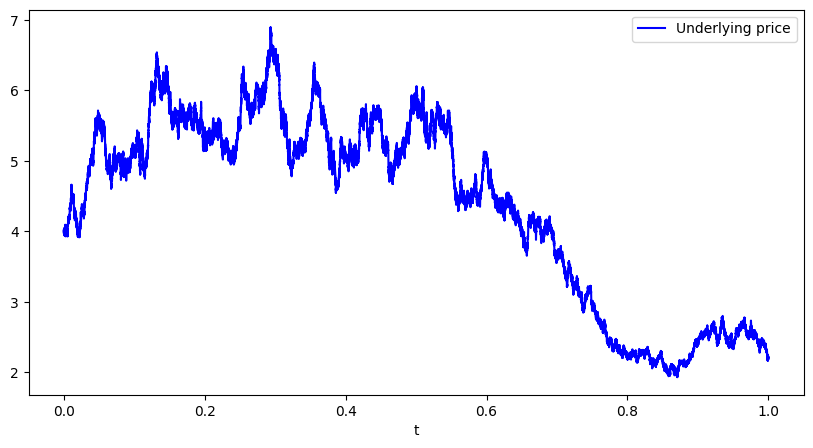

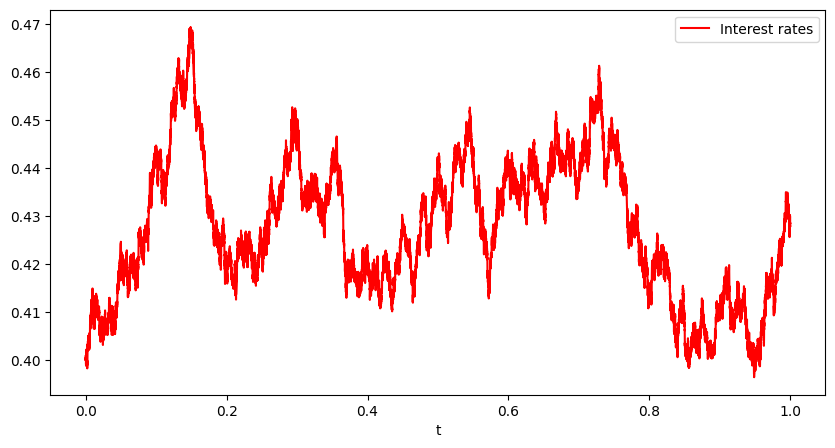

In [42]:
# Plotting underlying price and rates
_ = ep.trajectories[1].plot(y="S", x = "t", figsize=(10, 5), label="Underlying price", color="blue")
_ = ep.trajectories[1].plot(y="r", x = "t", figsize=(10, 5), label="Interest rates", color="red")

#### Asian option pricing

In [33]:
# Model parameters
S0 = 4
sigma = 0.7
rho = 0.5
r = CIR(0.4, 0.20, 0.01, 0.12) # Vasicek(0.01875, 0.20, 0.01, 0.014)
model = BlackScholes(S0, r, sigma, rho)

In [34]:
# Define the Asian pricer
ap = AsianPricer(udl_model=model, preCompute=True)

Pre-computing the equity trajectories
Simulating trajectories
-------------- Generation of Brownian Motions --------------
Simulated rho: -0.2471066089591624 	Given rho: 0.5
Absolute error: 0.7471066089591624
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.5804849692851781 	Given rho: 0.5
Absolute error: 0.08048496928517812
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.9705488789674743 	Given rho: 0.5
Absolute error: 0.4705488789674743
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.955431127463747 	Given rho: 0.5
Absolute error: 0.45543112746374703
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.6742521097018902 	Given rho: 0.5
Absolute error: 0.1742521097018902
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.8265660153991324 	Given rho: 0.5
Absolute error: 0.32656601539913244
-------------- Generation of Brownian Motions -------------

-------------- Generation of Brownian Motions --------------
Simulated rho: 0.8397701810908249 	Given rho: 0.5
Absolute error: 0.3397701810908249
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.48732227416947754 	Given rho: 0.5
Absolute error: 0.012677725830522457
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.5288571268642344 	Given rho: 0.5
Absolute error: 0.02885712686423436
-------------- Generation of Brownian Motions --------------
Simulated rho: -0.162235917289359 	Given rho: 0.5
Absolute error: 0.662235917289359
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.4865387825964388 	Given rho: 0.5
Absolute error: 0.01346121740356121
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.31505758325247996 	Given rho: 0.5
Absolute error: 0.18494241674752004
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.440659196958726 	Given rho: 0.5
Absolute

-------------- Generation of Brownian Motions --------------
Simulated rho: -0.3225389836187419 	Given rho: 0.5
Absolute error: 0.8225389836187419
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.8860695679348888 	Given rho: 0.5
Absolute error: 0.3860695679348888
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.9609753522154642 	Given rho: 0.5
Absolute error: 0.46097535221546415
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.8314832723248204 	Given rho: 0.5
Absolute error: 0.33148327232482044
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.09000864079612474 	Given rho: 0.5
Absolute error: 0.40999135920387525
-------------- Generation of Brownian Motions --------------
Simulated rho: -0.0603668678178079 	Given rho: 0.5
Absolute error: 0.5603668678178079
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.459489922158738 	Given rho: 0.5
Absolute

-------------- Generation of Brownian Motions --------------
Simulated rho: 0.3384919806220628 	Given rho: 0.5
Absolute error: 0.16150801937793718
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.2371592126307296 	Given rho: 0.5
Absolute error: 0.2628407873692704
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.9425290442436751 	Given rho: 0.5
Absolute error: 0.4425290442436751
-------------- Generation of Brownian Motions --------------
Simulated rho: -0.14248846564081982 	Given rho: 0.5
Absolute error: 0.6424884656408199
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.47409353826589784 	Given rho: 0.5
Absolute error: 0.02590646173410216
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.5041431959677686 	Given rho: 0.5
Absolute error: 0.004143195967768576
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.7494873722833714 	Given rho: 0.5
Absolu

-------------- Generation of Brownian Motions --------------
Simulated rho: 0.2405862979601913 	Given rho: 0.5
Absolute error: 0.25941370203980874
-------------- Generation of Brownian Motions --------------
Simulated rho: -0.39321810892021236 	Given rho: 0.5
Absolute error: 0.8932181089202124
-------------- Generation of Brownian Motions --------------
Simulated rho: -0.1778246916754093 	Given rho: 0.5
Absolute error: 0.6778246916754093
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.9672060851623486 	Given rho: 0.5
Absolute error: 0.4672060851623486
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.9406702094224692 	Given rho: 0.5
Absolute error: 0.44067020942246915
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.5252957955073533 	Given rho: 0.5
Absolute error: 0.02529579550735328
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.2804981671481748 	Given rho: 0.5
Absolut

-------------- Generation of Brownian Motions --------------
Simulated rho: 0.8552346710283492 	Given rho: 0.5
Absolute error: 0.35523467102834916
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.3227316650999457 	Given rho: 0.5
Absolute error: 0.17726833490005428
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.45554663666478706 	Given rho: 0.5
Absolute error: 0.044453363335212936
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.5644570484121221 	Given rho: 0.5
Absolute error: 0.06445704841212208
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.6323776581111649 	Given rho: 0.5
Absolute error: 0.13237765811116486
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.8621102945001288 	Given rho: 0.5
Absolute error: 0.36211029450012877
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.7505869257447223 	Given rho: 0.5
Absol

-------------- Generation of Brownian Motions --------------
Simulated rho: 0.9204575623409114 	Given rho: 0.5
Absolute error: 0.42045756234091136
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.8940505198241527 	Given rho: 0.5
Absolute error: 0.39405051982415273
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.5299840453490282 	Given rho: 0.5
Absolute error: 0.02998404534902821
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.36112486077014627 	Given rho: 0.5
Absolute error: 0.13887513922985373
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.6668086065533192 	Given rho: 0.5
Absolute error: 0.1668086065533192
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.7999904250307802 	Given rho: 0.5
Absolute error: 0.2999904250307802
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.1622461220443086 	Given rho: 0.5
Absolute

-------------- Generation of Brownian Motions --------------
Simulated rho: 0.7948707442648619 	Given rho: 0.5
Absolute error: 0.29487074426486193
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.8999987546618372 	Given rho: 0.5
Absolute error: 0.3999987546618372
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.87679015418705 	Given rho: 0.5
Absolute error: 0.37679015418705
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.817337624803402 	Given rho: 0.5
Absolute error: 0.317337624803402
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.9344362989715159 	Given rho: 0.5
Absolute error: 0.4344362989715159
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.7706503410994988 	Given rho: 0.5
Absolute error: 0.2706503410994988
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.822646821120341 	Given rho: 0.5
Absolute error: 0.3

-------------- Generation of Brownian Motions --------------
Simulated rho: 0.11248979577385493 	Given rho: 0.5
Absolute error: 0.38751020422614507
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.8796407137074848 	Given rho: 0.5
Absolute error: 0.37964071370748476
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.033752753666339605 	Given rho: 0.5
Absolute error: 0.4662472463336604
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.9112922774978961 	Given rho: 0.5
Absolute error: 0.4112922774978961
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.6676277116019405 	Given rho: 0.5
Absolute error: 0.16762771160194045
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.8914126837758647 	Given rho: 0.5
Absolute error: 0.3914126837758647
-------------- Generation of Brownian Motions --------------
Simulated rho: 0.378019664590764 	Given rho: 0.5
Absolute

In [35]:
ap

In [36]:
ap.isSimulated

True

In [38]:
K = 1
# Call price
ap.compute_option_price(K=K, contract=Constants.Contract.CALL)

2.6526818519573845

In [39]:
# Call price
ep.compute_option_price_call(K)

3.163666602214919

In [41]:
# Put price
ep.compute_option_price_put(K)

0.00347558337004838

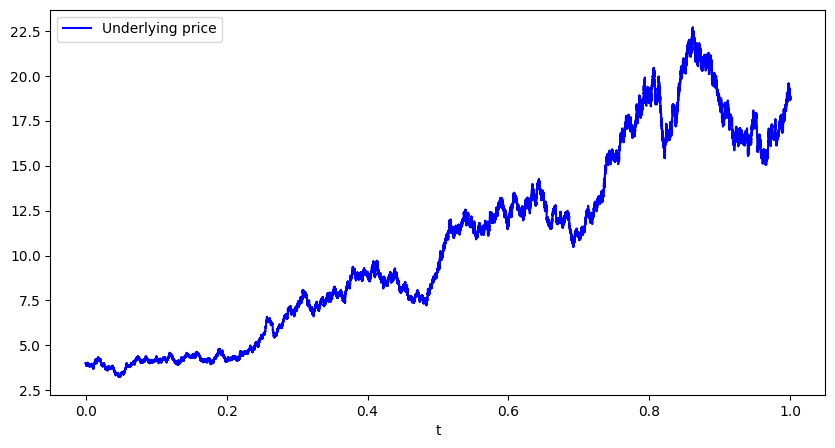

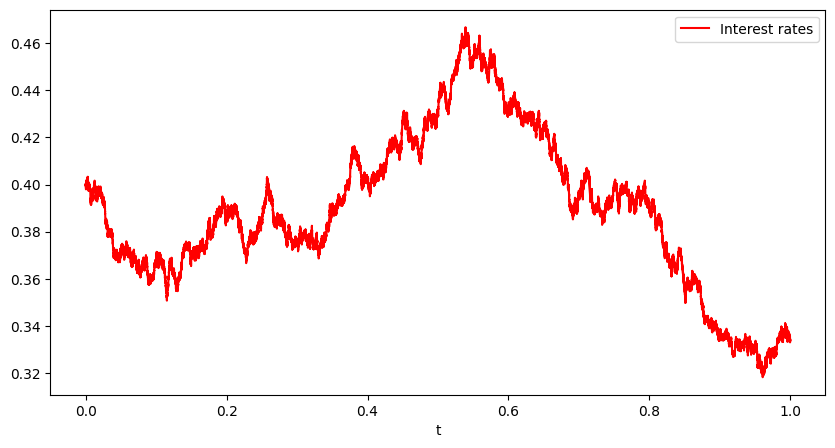

In [43]:
# Plotting underlying price and rates
_ = ap.trajectories[1].plot(y="S", x = "t", figsize=(10, 5), label="Underlying price", color="blue")
_ = ap.trajectories[1].plot(y="r", x = "t", figsize=(10, 5), label="Interest rates", color="red")

## Miscellaneous

In [44]:
from tqdm.notebook import trange, tqdm

In [53]:
for i in trange(100000, colour="blue"):
    pass

  0%|          | 0/100000 [00:00<?, ?it/s]

### Simulation of the joint distribution $\Big(\int_0^T r_u \mathrm{d}u, S_T\Big) $

### Model refinement $\longrightarrow$ Constant to time-varying parameters

#### <u>Interest rates dynamics</u> $\leadsto$ <span style="background:gray; color:white; padding: 2px 6px">$t \longmapsto \theta(t)$ instead of $\theta \in \mathbb{R}^+$</span>

$\longrightarrow$ Check [**Hull \& White** model](#Hull-&-White-(HW)-$\diamond$-Extended-Vasicek)

#### <u>Equity index dynamics</u> $\leadsto$ <span style="background:gray; color:white; padding: 2px 6px">$t \longmapsto \sigma(t)$ instead of $\sigma \in \mathbb{R}^+$</span>

---
**Amal BACHA - Dalia BARBI - Khalil BATTIKH - Lucas RODRIGUEZ - Naïm SOUNI**
